## Install libraries

In [1]:
# !pip install fastparquet
# !pip install lightgbm
# !pip install scikit-plot

## Load data from customized data pre-precessing library

In [2]:
# Importing self-created functions
from mi_charge_data import *
# dir(mi_charge_data)

X_train, X_test, y_train, y_test, features = get_data(hcpcs=False)

## Model comparison and selection

In [3]:
from sklearn import linear_model # LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

from sklearn import metrics # r2_score, mae, mse

# Initial model selection using default setting
models = dict(
    ridgeReg = linear_model.Ridge(), 
    # ridgeReg = linear_model.Ridge(alpha=0.2, max_iter=100000), 
    ols = linear_model.LinearRegression(), 
    sgdReg = linear_model.SGDRegressor(random_state=42),
    lassoReg = linear_model.Lasso(), 
    bayesianReg = linear_model.BayesianRidge(),     
    ransactReg = linear_model.RANSACRegressor(random_state=42), #robust to outliers? 0.44
    # ransactReg = linear_model.RANSACRegressor(min_samples=5000, max_trials=10000, loss='absolute_error', random_state=42), # 0.59
    #svmReg = SVR(), # running forever
    decisionTree = DecisionTreeRegressor(max_depth=3, random_state = 42),
    # randomForestReg = RandomForestRegressor(max_depth=3, random_state = 42), 
    randomForestReg = RandomForestRegressor(max_depth=11, n_estimators = 80,  random_state = 42),    
    adaBoostReg = AdaBoostRegressor(n_estimators=10, random_state=42),
    # adaBoostReg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100, random_state=42),
    knn = KNeighborsRegressor(),
    lightgbm = ''
)

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/dask/dataframe/utils.py:366: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/dask/dataframe/utils.py:366: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/dask/dataframe/utils.py:366: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [4]:
def train_eval_model(modeldef, modelname, X_train, X_test, y_train, y_test):
    if modelname == 'lightgbm':
        mod, y_pred = lightgbm_model(X_train, X_test, y_train, y_test)
        r2_test = metrics.r2_score(y_test, y_pred)
        r2_train = r2_test
    else: 
        mod = modeldef[modelname]
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)

        # model evaluation
        r2_train = mod.score(X_train, y_train)
        r2_test = mod.score(X_test, y_test)

    # r2 = metrics.r2_score(y_test, y_pred)  # same as r2_test
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

    additn = None
    # for linear model
    if modelname in ['ols', 'ridgeReg', 'sgdReg', 'lassoReg', 'bayesianReg', 'svmReg']:
        additn = mod.coef_, mod.intercept_
    elif modelname in ['decisionTree', 'randomForestReg']:
        additn = mod.feature_importances_
    elif modelname in ['adaBoostReg']:
        additn = mod.n_features_in_

    return r2_train, r2_test, mae, rmse, additn


In [5]:
def lightgbm_model(X_train, X_test, y_train, y_test):

    # specify your configurations as a dict
    params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
    }

    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # train
    # print('Starting training...')
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                callbacks=[lgb.early_stopping(stopping_rounds=5)])

    # save model to file
    # print('Saving model...')
    # gbm.save_model('model.txt')

    # predict
    # print('Starting predicting...')
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    return gbm, y_pred


In [6]:
scores = {}
# all models
for model in models:
    scores[model] = train_eval_model(models, model, X_train, X_test, y_train, y_test)    
    
# just test one model
# scores['lightgbm']= train_eval_model(models, 'lightgbm', X_train, X_test, y_train, y_test)
# scores

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's l2: 587807	valid_0's l1: 202.351


In [7]:
df_score = pd.DataFrame(scores).T
df_score.columns=['Train R2', 'Test R2', 'MAE', 'RMSE','other']
# df_score.drop(['MSE', 'other'], axis=1, inplace=True)
df_score

,Train R2,Test R2,MAE,RMSE,other
ridgeReg,0.624905,0.636173,194.578085,602.520429,"([-9.351887293785564, 0.12730854786684603, -3...."
ols,0.624905,0.636177,194.582109,602.517349,"([-9.35653967409574, 0.12746421607713504, -3.0..."
sgdReg,0.513995,0.508714,217.466064,700.15087,"([16.41249092162283, 59.39448730457545, -73.39..."
lassoReg,0.624195,0.633492,194.15672,604.736065,"([-8.489526203621988, -0.0, -2.763382396906428..."
bayesianReg,0.624905,0.636163,194.566983,602.529231,"([-9.33895080141997, 0.1268742136201979, -3.04..."
ransactReg,0.44813,0.469532,177.366063,727.535341,NaN
decisionTree,0.649024,0.654865,193.922847,586.839189,"[0.0, 0.0, 0.0, 0.0836276769364663, 0.58417479..."
randomForestReg,0.839985,0.708367,149.398748,539.439861,"[0.017853685748245238, 0.022499280836907328, 0..."
adaBoostReg,0.265535,0.348194,298.680978,806.461412,10.0
knn,0.792616,0.685562,151.210501,560.13418,NaN


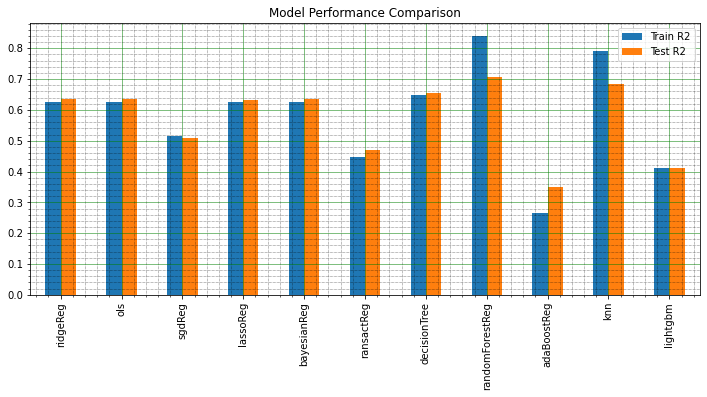

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (12.0, 5.0)
df_score.plot(y=['Train R2', 'Test R2'], kind="bar", title="Model Performance Comparison")
# df_score.plot(y=['Train R2', 'Test R2'], kind="line", title="Model Performance Comparison")
# Turn on the grid
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.show()

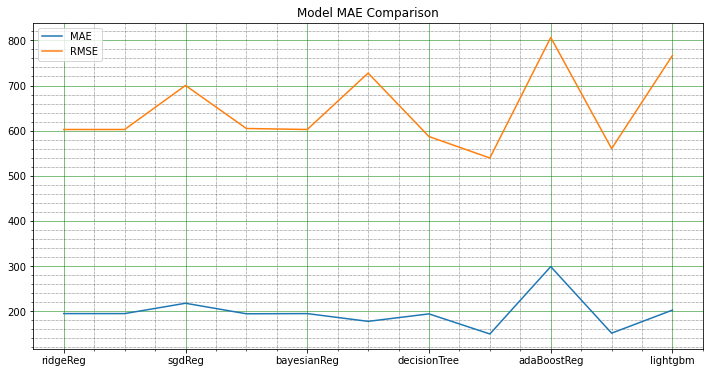

In [9]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
df_score.plot(y=['MAE', 'RMSE'], kind="line", title="Model MAE Comparison")
# Turn on the grid
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

plt.show()

## Selected top models tuning

In [10]:
# Top 3 Models Tuning
models_selected=dict(
    decisionTree = DecisionTreeRegressor(max_depth=5, random_state = 42),    
    knn=KNeighborsRegressor(n_neighbors=27, weights='distance', n_jobs=-1),
    randomForestReg = RandomForestRegressor(max_depth=11, n_estimators = 80, criterion="absolute_error", random_state = 42),
)

In [11]:
def knn_params(X_train, X_test, y_train, y_test):
    score = [0,0]
    for k in range(1,38):
        mod = KNeighborsRegressor(n_neighbors=k, weights='distance', n_jobs=-1)
        mod.fit(X_train, y_train)
        kscore = mod.score(X_test, y_test)        
        if kscore > score[1]:
            score = [k, kscore, mod.score(X_train, y_train)]
    return score

knn_params(X_train, X_test, y_train, y_test)
# [24, 0.6893155548773102, 0.9998568007876647]

[31, 0.7089562709993827, 0.9998240179218806]

In [12]:
def decision_tree_params(X_train, X_test, y_train, y_test):
    score = [0,0]
    for k in range(1,10):
        mod = DecisionTreeRegressor(max_depth=k, random_state = 42)
        mod.fit(X_train, y_train)
        kscore = mod.score(X_test, y_test)
        # print(k, type(s), s)
        if kscore > score[1]:
            score = [k, kscore, mod.score(X_train, y_train)]
    return score

decision_tree_params(X_train, X_test, y_train, y_test)

[5, 0.669603725992185, 0.7151316906844656]

[5, 0.669603725992185, 0.7151316906844656]

In [13]:
def random_forest_params(X_train, X_test, y_train, y_test):
    score = [0,0,0]
    decreases = 0
    for k in range(1,20):
        mod = RandomForestRegressor(max_depth=k, random_state = 42)
        mod.fit(X_train, y_train)
        kscore = mod.score(X_test, y_test)
        if kscore > score[1]:
            score = [k, kscore, mod.score(X_train, y_train)]
        else:
            decreases += 1
        if decreases > 3:
            break
    return score

random_forest_params(X_train, X_test, y_train, y_test)
# [11, 0.6920899584135215, 0.8327490435554471]

# [17, 0.6875431781997527, 0.8295467713180223]?

[15, 0.7147414917048909, 0.8971043947066]

In [14]:
def random_forest_params2(X_train, X_test, y_train, y_test):
    score = [0,0,0]
    decreases = 0
    for d in range(1,20):
        for e in range(10,500):
            mod = RandomForestRegressor(max_depth=d, n_estimators=e, random_state = 42)
            mod.fit(X_train, y_train)
            testscore = mod.score(X_test, y_test)
            if testscore > score[2]:
                score = [d, e, testscore]
                decreases = 0
            else:
                decreases += 1
            if decreases > 5:
                break
                
    # find train score for selected parameter
    mod = RandomForestRegressor(max_depth=score[0], n_estimators=score[1], random_state = 42)
    mod.fit(X_train, y_train)
    trainscore = mod.score(X_train, y_train)
    score = [trainscore, score[2], score[0], score[1]]
    
    return score

r2_train, r2_test, best_depth, best_estimator = random_forest_params2(X_train, X_test, y_train, y_test)
# [0.8019191279236988, 0.7088181949646113, 9, 22]

In [15]:
from sklearn.model_selection import GridSearchCV

def random_forest_search(X_train, X_test, y_train, y_test):
    mod = RandomForestRegressor(max_depth=11, random_state = 42, n_jobs=-1)
    param_grid = { 
        'n_estimators': [10, 20, 50, 80, 90, 100, 300],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [5,6,7,8,9,10,11,12],
#         'criterion' :['squared_error', 'absolute_error', 'poisson']
        'criterion' :['mse', 'poisson']
    }
    grid = GridSearchCV(estimator=mod, param_grid=param_grid, cv= 5)
    grid.fit(X_train, y_train)

    return grid.best_score_, grid.best_params_

random_forest_search(X_train, X_test, y_train, y_test)

# (0.6963683409469337, {'criterion': 'mse',  'max_depth': 8,  'max_features': 'auto',  'n_estimators': 300})

## Selected best performance model and evaluation

In [16]:
# best performance model
from sklearn.model_selection import cross_val_score

mod = RandomForestRegressor(max_depth=best_depth, n_estimators=best_estimator, random_state = 42)
mod.fit(X_train, y_train)

y_pred = mod.predict(X_test)

# Perform K-Fold CV
cvscore = cross_val_score(mod, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print('randomForestReg CV scores:', cvscore)

# model evaluation
r2_train = mod.score(X_train, y_train)
r2_test = mod.score(X_test, y_test)

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)

print('best randomForestReg:', cvscore, r2_train, r2_test, mae, mse)

# 'randomForestReg': (0.8325314806060101,  0.6936608715388014,  0.6936608715388014,  152.1980130722941,  278267.40104283777,  None)


randomForestReg CV scores: [-154.63289759 -156.84346585 -151.11870642 -152.22202511 -152.53643842]
best randomForestReg: [-154.63289759 -156.84346585 -151.11870642 -152.22202511 -152.53643842] 0.8019191279236988 0.7088181949646113 154.24582445021449 290544.78083418123


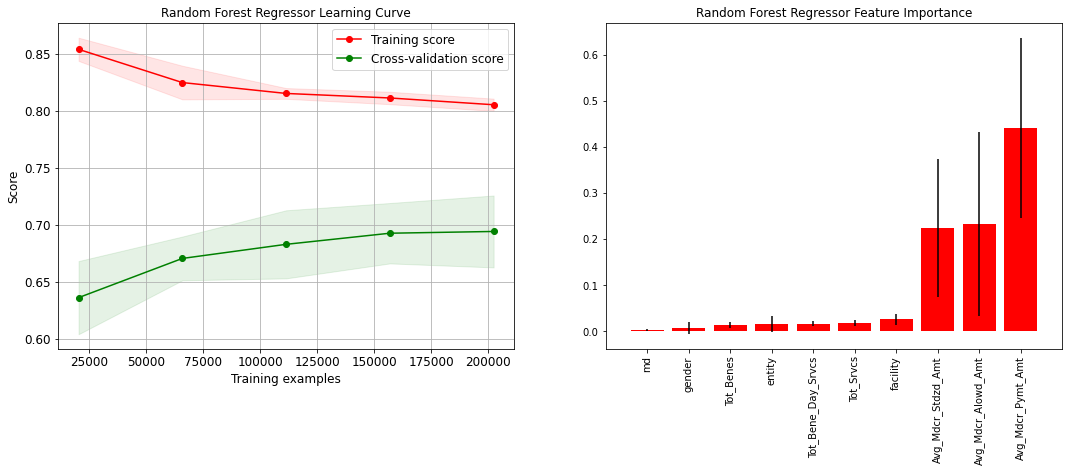

In [17]:
import scikitplot as skplt

fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(121)
skplt.estimators.plot_learning_curve(mod, X_train, y_train,
                                     cv=5, shuffle=True, scoring="r2",
                                     n_jobs=-1, title_fontsize="large", text_fontsize="large",
                                     title="Random Forest Regressor Learning Curve", ax=ax1)

ax2 = fig.add_subplot(122)
skplt.estimators.plot_feature_importances(mod, feature_names=features,
                                         title="Random Forest Regressor Feature Importance",
                                         x_tick_rotation=90, order="ascending", ax=ax2);


## Prediction result analysis

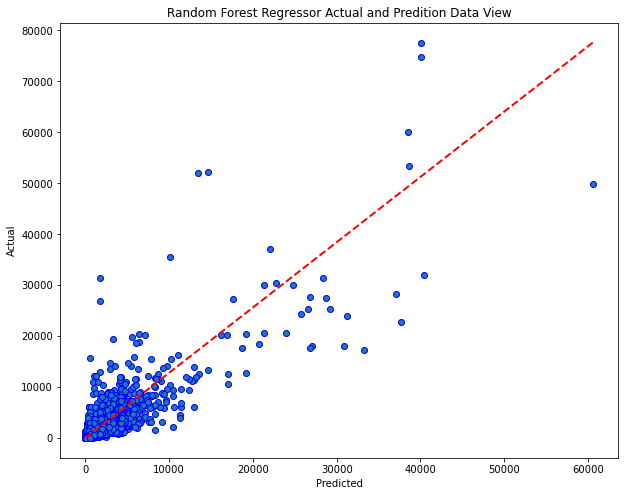

In [18]:
df_preds = pd.DataFrame({"preds":y_pred, "actual":y_test})
df_preds["residuals"] = df_preds["actual"] - df_preds["preds"]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.scatter(df_preds.preds, df_preds.actual, edgecolors=(0, 0, 1))
ax.plot([df_preds.preds.min(), df_preds.preds.max()], [df_preds.actual.min(), df_preds.actual.max()], 'r--', lw=2)
# ax.plot(df_preds.preds, df_preds.preds, 'r--', lw=2)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Random Forest Regressor Actual and Predition Data View')
plt.show()

In [19]:
df_preds.describe()

,preds,actual,residuals
count,84338.000000,84338.000000,84338.000000
mean,321.256514,322.748496,1.491981
std,806.918603,998.911463,539.023190
min,4.667553,0.010000,-16001.489957
25%,70.685021,60.000000,-69.655210
50%,171.151715,139.000000,-16.200186
75%,338.113263,270.000000,10.713825
max,60558.863240,77598.490000,38527.530750


In [20]:
df_preds.sort_values(['residuals'], ascending=False).head(10)

,preds,actual,residuals
5667512,13472.469250,52000.000000,38527.530750
6211734,40038.640405,77598.490000,37559.849595
5667511,14632.308107,52150.000000,37517.691893
6565207,40048.210722,74769.347500,34721.136778
1584908,1761.782127,31326.315789,29564.533662
9905987,10069.161924,35492.000000,25422.838076
3009811,1708.602894,26911.277586,25202.674692
8826247,38453.335177,59999.190476,21545.855299
2551382,3274.496293,19350.000000,16075.503707
6819796,495.528274,15650.000000,15154.471726


In [22]:
df = load_data()
df[round(df.Avg_Sbmtd_Chrg,0) == 52000]

,HCPCS_Cd,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,gender,entity,facility,md
5667512,22514,39,40.0,40,52000.0,6480.191,5162.13325,5506.36525,1,0,0,1


In [23]:
df[df.HCPCS_Cd == '22514']

,HCPCS_Cd,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,gender,entity,facility,md
249852,22514,16,17.0,17,7000.000000,315.460588,252.260588,231.685882,1,0,1,1
462010,22514,20,21.0,21,5959.000000,528.620000,421.180000,393.880000,1,0,1,1
572561,22514,11,11.0,11,3785.000000,535.830000,428.390000,400.154545,1,0,1,1
576365,22514,12,12.0,12,1470.000000,528.620000,421.180000,393.880000,1,0,1,1
786243,22514,11,13.0,13,1424.769231,508.897692,405.590000,378.730000,1,0,1,1
952902,22514,16,17.0,17,9600.000000,6397.529412,5106.214118,5505.138824,1,0,0,1
1281271,22514,23,23.0,23,1214.347826,463.069565,363.208696,336.195652,1,0,1,1
1386694,22514,16,17.0,17,1595.000000,482.420000,384.370000,393.880000,1,0,1,1
2099057,22514,11,12.0,12,950.000000,517.476667,413.616667,380.748333,1,0,1,1
3394052,22514,12,13.0,13,12472.000000,6445.327692,5154.636154,5507.400769,1,0,0,1


In [24]:
df[df.HCPCS_Cd == '22514'].describe()

,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,gender,entity,facility,md
count,20.00000,20.00000,20.00000,20.000000,20.000000,20.000000,20.000000,20.0,20.0,20.000000,20.0
mean,17.20000,18.50000,18.50000,6761.005853,1978.106116,1577.924248,1657.967425,1.0,0.0,0.750000,1.0
std,6.91756,7.28011,7.28011,11435.587045,2642.741625,2109.081857,2278.835660,0.0,0.0,0.444262,0.0
min,11.00000,11.00000,11.00000,950.000000,315.460588,252.260588,231.685882,1.0,0.0,0.000000,1.0
25%,12.00000,13.00000,13.00000,1400.000000,483.312500,385.022187,382.510958,1.0,0.0,0.750000,1.0
50%,16.00000,17.00000,17.00000,1602.500000,519.504762,414.655833,393.880000,1.0,0.0,1.000000,1.0
75%,20.00000,21.50000,21.50000,7650.000000,2001.254853,1597.846029,1674.270826,1.0,0.0,1.000000,1.0
max,39.00000,40.00000,40.00000,52000.000000,6480.191000,5162.133250,5507.400769,1.0,0.0,1.000000,1.0
